# Deep Learning-Based for Automatic Landmark Localization in Medical Images

### Librairies

In [72]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, concatenate, Conv2D, Conv2DTranspose, Dropout, Input, MaxPooling2D
from tensorflow.keras.models import Model

### Loading training data

In [73]:
# Initialization of variables
train_data = []                # List to store all training informations from csv files
train_images = []              # Training images
train_labels = []              # Training labels       
original_shape = (2400, 1935)  # Original shape of images
new_shape = (256,256)          # New shape
w = 20                         # Size of the markers around the landmark

# Reading csv
train_data.append(pd.read_csv('../data/cephalometric-landmarks/train_senior.csv', delimiter=','))  # Training data
train_data.append(pd.read_csv('../data/cephalometric-landmarks/test1_senior.csv', delimiter=','))  # Validation data

# Reading all images
for csv_file in train_data:
    for row in csv_file.values:
        landmarks = list(row)

        # Reading image
        image = cv2.imread('../data/cephalometric-landmarks/cepha400/' + landmarks[0], 0)

        # Normalisation of images
        image = image / 255
        
        # Markers initialization
        markers = np.zeros((image.shape[0],image.shape[1],1))
        
        # Addings markers around landmarks
        for i in range(1, 38, 2):
            x = landmarks[i]
            y = landmarks[i+1]
            markers[y - w:y + w , x - w:x + w , 0] = 1

        # Resizing images and labels
        image = cv2.resize(image,(256,256))
        image = image.reshape((image.shape[0],image.shape[1],1))
        markers = cv2.resize(markers,(256,256))

        # Storing images 
        train_images.append(image)
        train_labels.append(markers)

# Transform list to array
train_images = np.stack(train_images, axis=0)
train_labels = np.stack(train_labels, axis=0)

# Messages display
print("Number of training images :", len(train_images))
print("Number of training labels :", len(train_labels))
print()
print("Shape of training images :", train_images.shape)
print("Shape of training labels :", train_labels.shape)

Number of training images : 300
Number of training labels : 300

Shape of training images : (300, 256, 256, 1)
Shape of training labels : (300, 256, 256)


### Plotting data

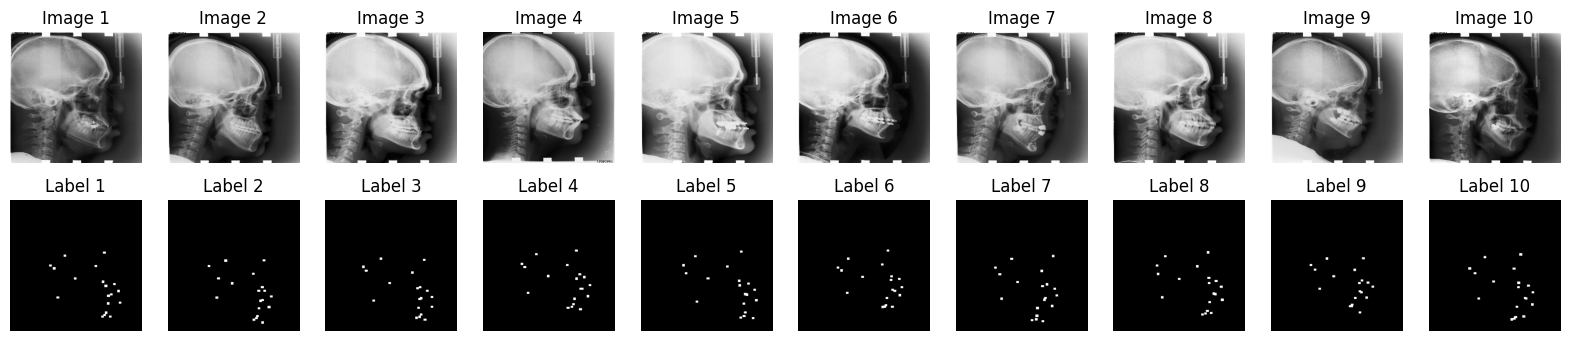

In [74]:
# Number of elements to display
num_elt = 10

# Images display
plt.figure(figsize=(20, 4))

# Afficher les éléments
for i in range(num_elt):
    plt.subplot(2, num_elt, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title('Image {}'.format(i+1))
    plt.axis('off')

    plt.subplot(2, num_elt, num_elt + i + 1)
    plt.imshow(train_labels[i], cmap='gray')
    plt.title('Label {}'.format(i+1))
    plt.axis('off')

plt.show()

## Neural networks

### U-Net model

In [75]:
def UNet(input_shape, num_classes=1):
    # Input shape of the model
    inputs = Input(input_shape)

    # First set of convolutional layers
    conv1 = Conv2D(64,  3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64,  3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)

    # Second set of convolutional layers
    conv2 = Conv2D(128,  3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128,  3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)

    # Third set of convolutional layers
    conv3 = Conv2D(256,  3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256,  3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)

    # Fourth set of convolutional layers
    conv4 = Conv2D(512,  3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512,  3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)

    # Contraction et Expansion (decoder)
    conv5 = Conv2D(1024,  3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024,  3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    # Upsampling and concatenation with skip connections for the first decoder block
    up6 = Conv2DTranspose(512, 3, strides=2, padding='same')(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    # Upsampling and concatenation with skip connections for the second decoder block
    up7 = Conv2DTranspose(256, 3, strides=2, padding='same')(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Upsampling and concatenation with skip connections for the third decoder block
    up8 = Conv2DTranspose(128, 3, strides=2, padding='same')(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    # Upsampling and concatenation with skip connections for the fourth decoder block
    up9 = Conv2DTranspose(64, 3, strides=2, padding='same')(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    con9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(up9)
    con9 = BatchNormalization()(con9)
    con9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(con9)
    con9 = BatchNormalization()(con9)

    # Output layer
    outputs = Conv2D(num_classes, kernel_size=1, activation='sigmoid', padding='same')(con9)

    # Model with inputs and outputs definition
    model = Model(inputs=[inputs], outputs=[outputs])

    return model

### Loading validation and test data

In [76]:
# Initialization of variables
valid_images = []  # Validation images
valid_labels = []  # Validation labels
test_images = []   # Test images
test_labels = []   # Test labels
count = 1          # Counter

test_labels_original = []

# Reading csv
val_test_data = pd.read_csv('../data/cephalometric-landmarks/test2_senior.csv', delimiter=',')  # Validation and test data

for row in val_test_data.values:
    landmarks = list(row)

    # Reading image
    image = cv2.imread('../data/cephalometric-landmarks/cepha400/' + landmarks[0], 0)

    # Normalisation of images
    image = image / 255

    # Markers initialization
    markers = np.zeros((image.shape[0],image.shape[1],1))

    # Addings markers around landmarks
    for i in range(1, 38, 2):
        x = landmarks[i]
        y = landmarks[i+1]
        markers[y - w:y + w , x - w:x + w , 0] = 1

    # Resizing images and labels
    image = cv2.resize(image,(256,256))
    image = image.reshape((image.shape[0],image.shape[1],1))
    markers_resize = cv2.resize(markers,(256,256))

    if count <= 50:
        valid_images.append(image)
        valid_labels.append(markers_resize)
    else:
        test_images.append(image)
        test_labels_original.append(markers)
        test_labels.append(markers_resize)

    count += 1

# Transform list to array
valid_images = np.stack(valid_images, axis=0)
valid_labels = np.stack(valid_labels, axis=0)
test_images = np.stack(test_images, axis=0)
test_labels = np.stack(test_labels, axis=0)

# Messages display
print("Number of validation images :", len(valid_images))
print("Number of validation labels :", len(valid_labels))
print("Number of test images :", len(test_images))
print("Number of test labels :", len(test_labels))
print()
print("Shape of validation images :", valid_images.shape)
print("Shape of validation labels :", valid_labels.shape)
print("Shape of test images :", test_images.shape)
print("Shape of test labels :", test_labels.shape)

Number of validation images : 50
Number of validation labels : 50
Number of test images : 50
Number of test labels : 50

Shape of validation images : (50, 256, 256, 1)
Shape of validation labels : (50, 256, 256)
Shape of test images : (50, 256, 256, 1)
Shape of test labels : (50, 256, 256)


### Loss function

In [77]:
def dice_coeff(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + 1e-7) / ( K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

    return dice

def dice_loss(y_true, y_pred):
    dice = dice_coeff(y_true, y_pred)
    
    return 1 - dice

### U-Net with Adam optimizer and dice loss function

In [ ]:
# Initialization of variables
input_shape = train_images[0].shape  # Inputs shape
learning_rate = 0.001                # Learning rate for the optimizer
epochs = 1                         # Number of epochs
batch_size = 32                      # Batch size

# Path for saving checkpoints
checkpoint_dir = 'models/unet'
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint-{epoch:02d}-{val_dice_coeff:.2f}.h5')

# Create the directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Callbacks for learning rate reduction and checkpoint saving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_dice_coeff', save_best_only=True, save_weights_only=False, verbose=1)

# Create and compile the model
model = UNet(input_shape=input_shape, num_classes=1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss=dice_loss, metrics=[dice_coeff])
model.summary()


In [ ]:
# Train the model
history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(valid_images, valid_labels), callbacks=[reduce_lr, checkpoint])

# Save the model
model.save('unet.h5')

### Plotting error

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training loss', 'val_loss'])

ax2.plot(history.history['val_dice_coeff'])
ax2.plot(history.history['dice_coeff'])
ax2.legend(['val_dice_coeff', 'dice_coeff'])

## Predictions

In [ ]:
predictions = model.predict(test_images)

If you need to make prediction with a pre-trained model

In [35]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({"dice_loss": dice_loss, "dice_coeff": dice_coeff})

# Load the model with the custom loss function
model_path = "models/unet/unet_150epochs.h5"
model = load_model(model_path, custom_objects={"dice_loss": dice_loss})

predictions = model.predict(test_images, verbose=1)
predictions = (predictions > 0.5).astype(np.float32)

2/2 [==============================] - 19s 7s/step


### Plotting predictions

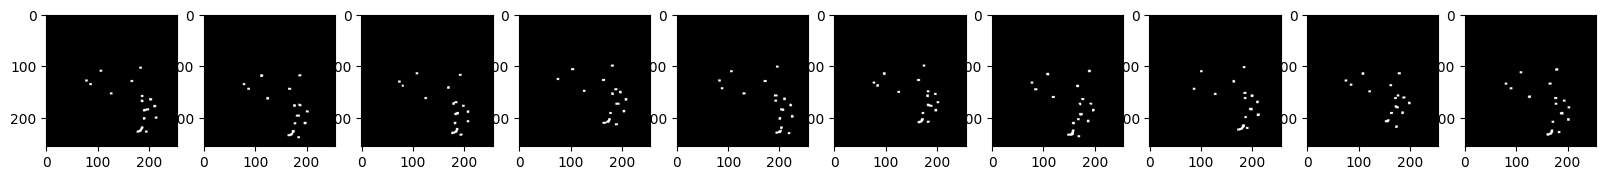

In [26]:
# Number of elements to display
num_elt = 10

# Images display
plt.figure(figsize=(20, 2))

# Afficher les éléments
for i in range(num_elt):
    plt.subplot(1, num_elt, i + 1)
    plt.imshow(predictions[i], cmap='gray')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


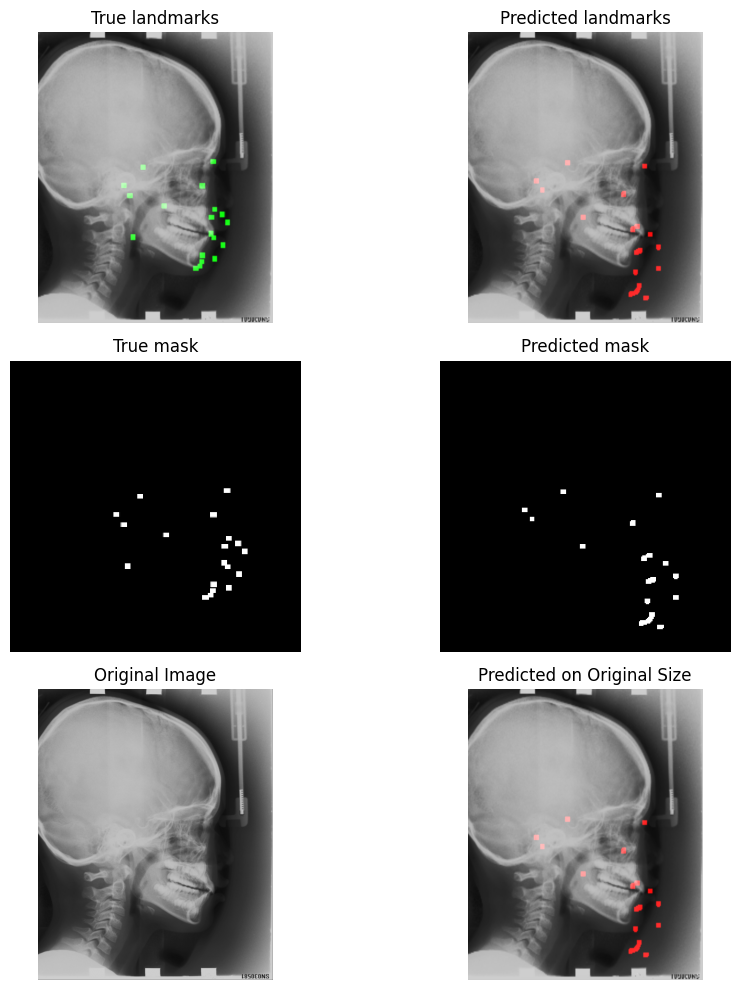

In [28]:
# Paramètres pour la taille des figures
plt.rcParams["figure.figsize"] = (10, 10)

# Index de l'image à afficher
idx = 2

# Extraire l'image de test en niveaux de gris
test_im_gray = test_images[idx]  # dimension (256, 256, 1)

# Convertir l'image en niveaux de gris pour cv2
test_im_gray_convert = test_im_gray[:, :, 0].astype(np.float32)  # cv2 accepte la dimension (256, 256) et float32

# Convertir en RGB
test_im_rgb = cv2.cvtColor(test_im_gray_convert, cv2.COLOR_GRAY2RGB)
im_copy = test_im_rgb.copy()

# Ajouter les labels vrais
test_im_rgb[:, :, 1] = test_im_rgb[:, :, 1] + test_labels[idx]

# Ajouter les prédictions
im_copy[:, :, 0] = im_copy[:, :, 0] + predictions[idx][:, :, 0]

# Charger l'image originale
origi_img = cv2.imread('../data/cephalometric-landmarks/cepha400/386.jpg') / 255

# Redimensionner les images à la taille de l'image originale
resized_true = cv2.resize(test_im_rgb, (origi_img.shape[1], origi_img.shape[0]))
resized_pred = cv2.resize(im_copy, (origi_img.shape[1], origi_img.shape[0]))

# Affichage des images
fig, axs = plt.subplots(3, 2)

# Affichage des vrais points de repère
axs[0, 0].imshow(resized_true)
axs[0, 0].set_title("True landmarks")
axs[0, 0].axis('off')

# Affichage des points de repère prédits
axs[0, 1].imshow(resized_pred)
axs[0, 1].set_title("Predicted landmarks")
axs[0, 1].axis('off')

# Affichage du masque vrai
axs[1, 0].imshow(test_labels[idx], cmap='gray')
axs[1, 0].set_title("True mask")
axs[1, 0].axis('off')

# Affichage du masque prédit
axs[1, 1].imshow(predictions[idx], cmap='gray')
axs[1, 1].set_title("Predicted mask")
axs[1, 1].axis('off')

# Affichage de l'image originale redimensionnée
axs[2, 0].imshow(origi_img)
axs[2, 0].set_title("Original Image")
axs[2, 0].axis('off')

# Réaffichage des points de repère et des prédictions redimensionnées
axs[2, 1].imshow(resized_pred)
axs[2, 1].set_title("Predicted on Original Size")
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()

(2400, 1935, 3)
(2400, 1935, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted')

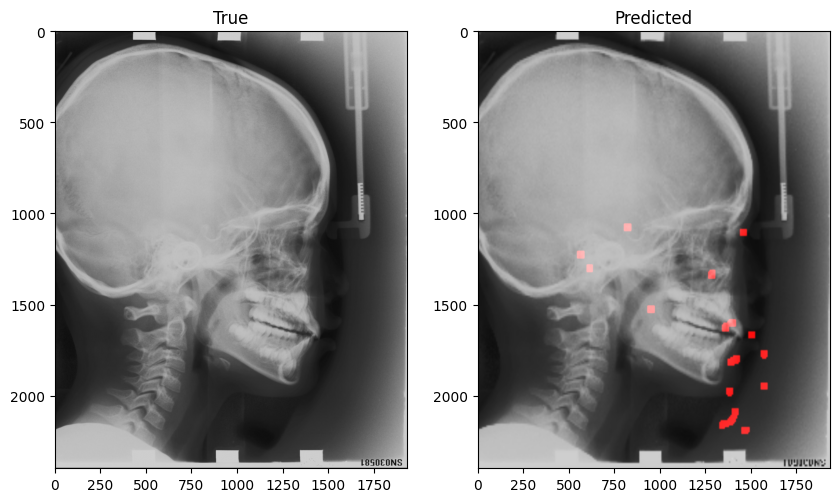

In [29]:
resized = cv2.resize(test_im_rgb, (1935,2400))

origi_img = cv2.imread('../data/cephalometric-landmarks/cepha400/386.jpg') / 255
print(origi_img.shape)
print(test_labels_original[0].shape)

im_copy_resized = cv2.resize(im_copy, (1935,2400))

plt.subplot(121)
plt.imshow(origi_img)
plt.title("True")

plt.subplot(122)
plt.imshow(resized_pred)
plt.title("Predicted")

## Model evaluation

In [30]:
model.evaluate(test_images, test_labels)

2/2 [==============================] - 20s 7s/step - loss: 0.4943 - dice_coeff: 0.5055


[0.4943230450153351, 0.5054957866668701]

## Mean euclidean distance error

In [62]:
from scipy.spatial.distance import cdist

def median_euclidean_distance_error(labels, predictions):
    errors = []
    for i in range(labels.shape[0]):
        label_points = np.argwhere(labels[i] == 1)
        pred_points = np.argwhere(predictions[i] >= 0.5)
        if len(label_points) == 0 or len(pred_points) == 0:
            continue
        # Calculer la distance euclidienne entre chaque point de repère dans label_points et pred_points
        distances = cdist(label_points, pred_points, 'euclidean')
        # Calculer l'erreur médiane de la distance euclidienne
        median_distance = np.median(distances)
        errors.append(median_distance / 50)
    return errors

# Assurez-vous que test_labels et predictions ont la même forme (50, 256, 256)
# Calculer l'erreur médiane de la distance euclidienne
med_euclidean_dist_error = median_euclidean_distance_error(test_labels, predictions)
print("Median Euclidean Distance Error:", np.median(med_euclidean_dist_error))


Median Euclidean Distance Error: 1.1875134018630038


### Plotting error

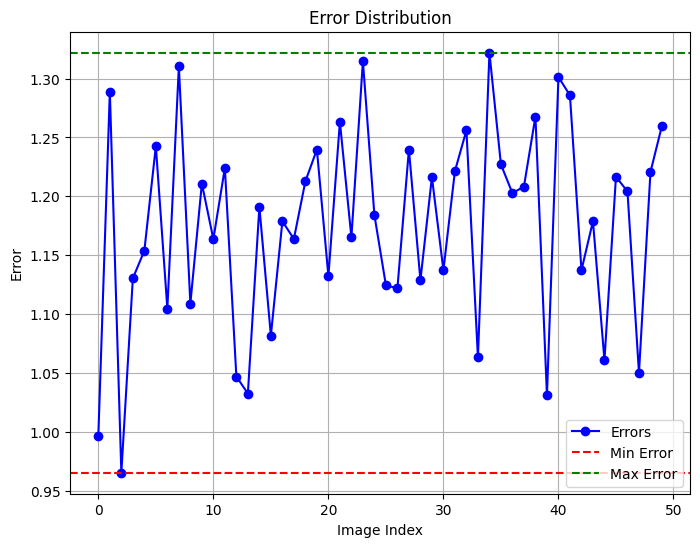

In [80]:
# Calcul de l'erreur minimale et maximale
min_error = min(med_euclidean_dist_error)
max_error = max(med_euclidean_dist_error)

# Plot des erreurs
plt.figure(figsize=(8, 6))
plt.plot(med_euclidean_dist_error, marker='o', linestyle='-', color='b', label='Errors')
plt.axhline(y=min_error, color='r', linestyle='--', label='Min Error')
plt.axhline(y=max_error, color='g', linestyle='--', label='Max Error')
plt.xlabel('Image Index')
plt.ylabel('Error')
plt.title('Error Distribution')
plt.legend()
plt.grid(True)
plt.show()